In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import glob
import os, cv2

In [2]:
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics

In [3]:
import imblearn

In [4]:
from sklearn.preprocessing import LabelEncoder
from keras import backend as K
from keras.utils.np_utils import to_categorical

In [5]:
from keras.preprocessing.image import ImageDataGenerator

In [6]:
from keras.models import Sequential,Model,load_model
from keras.layers import Dense,Input,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D,BatchNormalization,MaxPool2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D,AveragePooling2D,ReLU

In [7]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

In [8]:
RANDOM_STATE = 1054
DIRECTORY = "UTKFace/"
num_of_epochs = 30

In [9]:
def parse_filepath(filepath):
    
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        age, gender, race, _ = filename.split("_")
        return int(age)
    except Exception as e:
        print(filepath)
        return None

In [10]:
files = glob.glob(os.path.join(DIRECTORY, "*.jpg"))
data = list(map(parse_filepath, files))

UTKFace\39_1_20170116174525125.jpg.chip.jpg
UTKFace\61_1_20170109142408075.jpg.chip.jpg
UTKFace\61_1_20170109150557335.jpg.chip.jpg


In [11]:
df = pd.DataFrame(data)
df['file'] = files
df.columns = ['age', 'file']
df.head()

,age,file
0,100.0,UTKFace\100_0_0_20170112213500903.jpg.chip.jpg
1,100.0,UTKFace\100_0_0_20170112215240346.jpg.chip.jpg
2,100.0,UTKFace\100_1_0_20170110183726390.jpg.chip.jpg
3,100.0,UTKFace\100_1_0_20170112213001988.jpg.chip.jpg
4,100.0,UTKFace\100_1_0_20170112213303693.jpg.chip.jpg


In [12]:
df.shape

(23708, 2)

<AxesSubplot:>

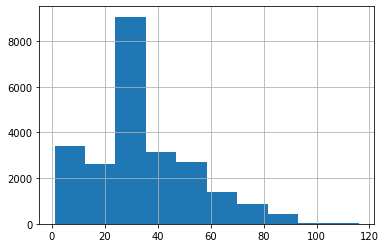

In [13]:
df['age'].hist()

In [14]:
def class_label(age):
    if 1 <= age <= 2:
        return 0
    elif 3 <= age <= 9:
        return 1
    elif 10 <= age <= 20:
        return 2
    elif 21 <= age <= 27:
        return 3
    elif 28 <= age <= 45:
        return 4
    elif 46 <= age <= 65:
        return 5
    else:
        return 6


In [15]:
df['target'] = df['age'].map(class_label)

In [16]:
df.head()

,age,file,target
0,100.0,UTKFace\100_0_0_20170112213500903.jpg.chip.jpg,6
1,100.0,UTKFace\100_0_0_20170112215240346.jpg.chip.jpg,6
2,100.0,UTKFace\100_1_0_20170110183726390.jpg.chip.jpg,6
3,100.0,UTKFace\100_1_0_20170112213001988.jpg.chip.jpg,6
4,100.0,UTKFace\100_1_0_20170112213303693.jpg.chip.jpg,6


<AxesSubplot:>

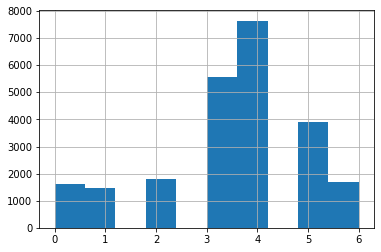

In [17]:
df['target'].hist()

In [18]:
df = df.sample(frac=0.65)

<AxesSubplot:>

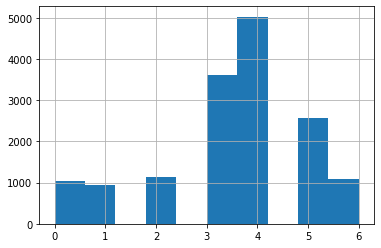

In [19]:
df['target'].hist()

In [20]:
X_files = df['file']
y = df['target']
X = []

In [21]:
df.head()

,age,file,target
8654,28.0,UTKFace\28_0_0_20170117202330366.jpg.chip.jpg,4
17301,48.0,UTKFace\48_0_0_20170111201211982.jpg.chip.jpg,5
5178,25.0,UTKFace\25_0_2_20170116170511407.jpg.chip.jpg,3
20607,60.0,UTKFace\60_1_0_20170117153656364.jpg.chip.jpg,5
21715,6.0,UTKFace\6_1_0_20170109194218239.jpg.chip.jpg,1


In [22]:
for img in X_files:
    image = cv2.imread(img, cv2.IMREAD_COLOR)
    X.append(np.array(image))

In [23]:
label_encoder= LabelEncoder()
Y = label_encoder.fit_transform(y)
Y = to_categorical(Y,7)

In [24]:
X = np.array(X)
X = X.astype('float32')
X=X/255.0

In [25]:
X.shape,Y.shape

((15410, 200, 200, 3), (15410, 7))

In [26]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.3, random_state=RANDOM_STATE, stratify=Y)

In [27]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10787, 200, 200, 3), (4623, 200, 200, 3), (10787, 7), (4623, 7))

In [28]:
X_train.shape, y_train.shape

((10787, 200, 200, 3), (10787, 7))

In [29]:
nsamples, nx, ny, nz = X_train.shape

In [30]:
d2_train = X_train.reshape((nsamples,nx*ny*nz))
d2_train.shape

(10787, 120000)

In [31]:
 rus = imblearn.under_sampling.RandomUnderSampler(random_state=RANDOM_STATE, sampling_strategy='auto')

In [32]:
X_train, y_train = rus.fit_resample(d2_train, y_train)
# X_train, y_train = rus.fit_resample(X_train, y_train)

In [33]:
X_train = X_train.reshape((-1,nx,ny,nz))
X_train.shape

(4599, 200, 200, 3)

In [34]:
augs_gen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.2,  
        height_shift_range=0.2, 
        horizontal_flip=True,  
        vertical_flip=False,
        validation_split=0.3) 

augs_gen.fit(X_train)

In [35]:
# net = Sequential()

# net.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(200,200,3)))
# BatchNormalization(),
# ReLU(),
# net.add(MaxPool2D(pool_size=(2,2)))

# net.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
# BatchNormalization(),
# ReLU(),
# net.add(MaxPool2D(pool_size=(2,2)))

# net.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
# BatchNormalization(),
# ReLU(),
# net.add(MaxPool2D(pool_size=(2,2)))

# net.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
# BatchNormalization(),
# ReLU(),
# net.add(MaxPool2D(pool_size=(2,2)))

# net.add(Dense(512, activation='relu'))
# BatchNormalization(),
# ReLU(),
# net.add(MaxPool2D(pool_size=(2,2)))

# net.add(Dense(1024, activation='relu'))
# BatchNormalization(),
# ReLU(),
# Dropout(0.5),
# net.add(Dense(7, activation='softmax'))

# net.summary()
net = Sequential()

net.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(200,200,3)))
net.add(AveragePooling2D(pool_size=(2,2)))

net.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
net.add(AveragePooling2D(pool_size=(2,2)))

net.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
net.add(AveragePooling2D(pool_size=(2,2)))

net.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
net.add(AveragePooling2D(pool_size=(2,2)))

net.add(GlobalAveragePooling2D())

net.add(Dense(132, activation='relu'))
net.add(Dense(7, activation='softmax'))

net.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 average_pooling2d (AverageP  (None, 99, 99, 32)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 average_pooling2d_1 (Averag  (None, 48, 48, 64)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 average_pooling2d_2 (Averag  (None, 23, 23, 128)      0

In [36]:
net.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [37]:
X_train.shape, y_train.shape

((4599, 200, 200, 3), (4599, 7))

In [38]:
history = net.fit(
                    augs_gen.flow(X_train, y_train, batch_size = 10,  subset='training'),
                    epochs = num_of_epochs,
                    verbose = 1,
                    validation_data  = augs_gen.flow(X_train, y_train, batch_size=8, subset='validation'),
                    )

Epoch 1/30
322/322 [==============================] - 106s 324ms/step - loss: 1.6449 - accuracy: 0.1904 - val_loss: 7.2851 - val_accuracy: 0.0000e+00
Epoch 2/30
322/322 [==============================] - 103s 321ms/step - loss: 1.6182 - accuracy: 0.2093 - val_loss: 7.1461 - val_accuracy: 0.0399
Epoch 3/30
322/322 [==============================] - 103s 321ms/step - loss: 1.6025 - accuracy: 0.2357 - val_loss: 6.8911 - val_accuracy: 0.0000e+00
Epoch 4/30
322/322 [==============================] - 102s 318ms/step - loss: 1.5910 - accuracy: 0.2460 - val_loss: 7.6561 - val_accuracy: 0.0000e+00
Epoch 5/30
322/322 [==============================] - 103s 319ms/step - loss: 1.5870 - accuracy: 0.2512 - val_loss: 8.7981 - val_accuracy: 0.0094
Epoch 6/30
322/322 [==============================] - 104s 323ms/step - loss: 1.5795 - accuracy: 0.2649 - val_loss: 7.7527 - val_accuracy: 0.0015
Epoch 7/30
322/322 [==============================] - 103s 318ms/step - loss: 1.5764 - accuracy: 0.2627 - val_lo

In [39]:
model = Sequential([
    Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(200,200,3)),
    BatchNormalization(),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Dense(4096, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(7, activation='softmax')
                                  ])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 96)       0         
 )                                                               
                                                                 
 conv2d_5 (Conv2D)           (None, 23, 23, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 23, 23, 256)      1024      
 hNormalization)                                                 
                                                      

In [40]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.1), metrics=['accuracy'])

In [ ]:
hi = model.fit(
                    augs_gen.flow(X_train, y_train, batch_size = 32,  subset='training'),
                    epochs = num_of_epochs,
                    verbose = 1,
                    validation_data  = augs_gen.flow(X_train, y_train, batch_size=8, subset='validation'),
                    )

In [ ]:
model.save('output/model2_001lr')